<a href="https://colab.research.google.com/github/pooriaazami/deep_learning_class_notebooks/blob/main/15_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision.transforms as T
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

import cv2 as cv

from tqdm.notebook import tqdm

from google.colab import files

In [2]:
BATCH_SIZE = 128
NOISE_DIM = 64

LR = 2e-4
BETA_1 = .5
BETA_2 = .99

EPOCHS = 20

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, .0, .02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, .2, .02)
    nn.init.constant_(m.bias, 0)

In [4]:
class DiscriminatorBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(.2)
    )

  def forward(self, x):
    return self.layers(x)

In [5]:
class GeneratorBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, output=False):
    super().__init__()

    if output:
      self.layers = nn.Sequential(
          nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
          nn.Tanh()
      )
    else:
      self.layers = nn.Sequential(
          nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )

  def forward(self, x):
    return self.layers(x)

In [6]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
      DiscriminatorBlock(1, 16, 3, 2).apply(initialize_weights),
      DiscriminatorBlock(16, 32, 5, 2).apply(initialize_weights),
      DiscriminatorBlock(32, 64, 5, 2).apply(initialize_weights),

      nn.Flatten(1),

      nn.Linear(64, 1)
    )

  def forward(self, x):
    return self.layers(x)

In [7]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super().__init__()
    self.noise_dim = noise_dim

    self.layers = nn.Sequential(
        GeneratorBlock(noise_dim, 256, 3, 2).apply(initialize_weights),
        GeneratorBlock(256, 128, 4, 1).apply(initialize_weights),
        GeneratorBlock(128, 64, 3, 2).apply(initialize_weights),
        GeneratorBlock(64, 1, 4, 2, True).apply(initialize_weights)
    )

  def forward(self, x):
    return self.layers(x)

In [8]:
def generate_plotting_images(plotting_noise, generator, nrow):
  with torch.no_grad():
    generated_images = generator(plotting_noise)
    generated_images = generated_images.cpu()
    grid_images = make_grid(generated_images, nrow=4).numpy().transpose((1, 2, 0))

  return grid_images

In [9]:
transforms = T.Compose([
    T.RandomRotation(20),
    T.ToTensor(),
])

train_dataset = MNIST(root='./data', download=True, train=True, transform=transforms)
test_dataset = MNIST(root='./data', download=True, train=False, transform=transforms)

dataset = ConcatDataset([train_dataset, test_dataset])
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 95304019.19it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21296711.29it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31587057.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18126097.78it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [17]:
generator = Generator(NOISE_DIM).to(DEVICE)
discriminator = Discriminator().to(DEVICE)

In [18]:
generator_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA_1, BETA_2))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA_1, BETA_2))

In [19]:
loss_function = nn.BCEWithLogitsLoss()

In [20]:
plotting_noise = torch.randn(16, NOISE_DIM, 1, 1, device=DEVICE)

In [21]:
discriminator_log = []
generator_log = []
plot_images = []

In [22]:
for epoch in range(1, EPOCHS + 1):
  print(f'Epoch {epoch} / {EPOCHS}')

  total_discriminator_loss = .0
  total_generator_loss = .0
  for x, _ in tqdm(dataloader):
    x = x.to(DEVICE)
    batch_size = x.size(0)

    # Discriminator
    discriminator_optimizer.zero_grad()

    noise = torch.randn(batch_size, NOISE_DIM, 1, 1, device=DEVICE)
    generated_images = generator(noise)
    generated_images_predictions = discriminator(generated_images)
    generated_images_loss = loss_function(generated_images_predictions, torch.zeros_like(generated_images_predictions))

    real_images_prediction = discriminator(x)
    real_images_loss = loss_function(real_images_prediction, torch.ones_like(real_images_prediction))

    discriminator_loss = generated_images_loss + real_images_loss
    discriminator_loss.backward()

    discriminator_optimizer.step()
    total_discriminator_loss += discriminator_loss.detach().cpu().item()

    # Generator
    generator_optimizer.zero_grad()

    noise = torch.randn(batch_size, NOISE_DIM, 1, 1, device=DEVICE)
    generated_images = generator(noise)
    generated_images_predictions = discriminator(generated_images)
    generator_loss = loss_function(generated_images_predictions, torch.ones_like(generated_images_predictions))

    generator_loss.backward()

    generator_optimizer.step()
    total_generator_loss += generator_loss.detach().cpu().item()

  print(f'Generator loss: {total_generator_loss:.2f}, Discriminator loss: {total_discriminator_loss:.2f}')
  discriminator_log.append(total_discriminator_loss)
  generator_log.append(total_generator_loss)
  new_plot_images = generate_plotting_images(plotting_noise, generator, 4)

  plot_images.append(new_plot_images)

Epoch 1 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 394.57, Discriminator loss: 728.78
Epoch 2 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 420.32, Discriminator loss: 689.26
Epoch 3 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 466.67, Discriminator loss: 631.99
Epoch 4 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 521.08, Discriminator loss: 577.04
Epoch 5 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 561.23, Discriminator loss: 554.15
Epoch 6 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 576.08, Discriminator loss: 554.42
Epoch 7 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 573.37, Discriminator loss: 572.00
Epoch 8 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 555.74, Discriminator loss: 596.54
Epoch 9 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 535.34, Discriminator loss: 621.76
Epoch 10 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 515.78, Discriminator loss: 641.76
Epoch 11 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 498.17, Discriminator loss: 659.42
Epoch 12 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 486.41, Discriminator loss: 676.07
Epoch 13 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 470.95, Discriminator loss: 686.85
Epoch 14 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 463.50, Discriminator loss: 696.00
Epoch 15 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 456.75, Discriminator loss: 702.47
Epoch 16 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 451.17, Discriminator loss: 707.85
Epoch 17 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 446.21, Discriminator loss: 713.27
Epoch 18 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 441.43, Discriminator loss: 716.39
Epoch 19 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 440.85, Discriminator loss: 717.15
Epoch 20 / 20


  0%|          | 0/547 [00:00<?, ?it/s]

Generator loss: 436.77, Discriminator loss: 719.52


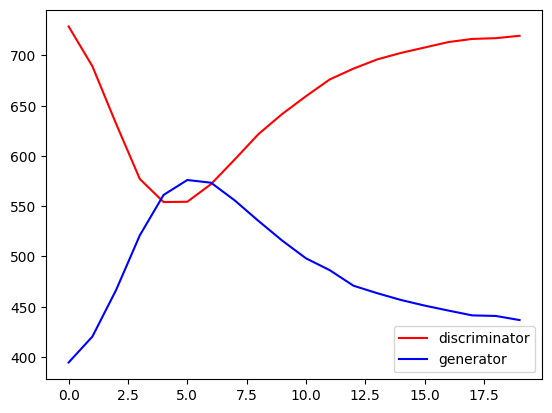

In [25]:
plt.plot(discriminator_log, color='red', label='discriminator')
plt.plot(generator_log, color='blue', label='generator')

plt.legend()
plt.show()

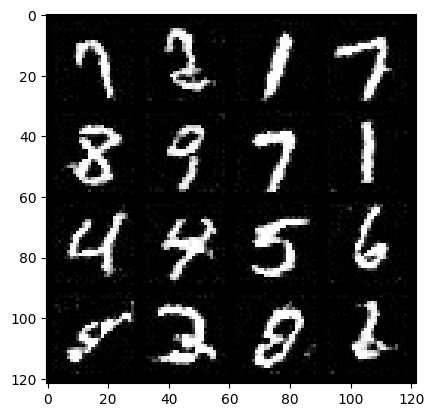

In [39]:
plt.imshow(plot_images[-1], cmap='gray')
plt.show()